<a href="https://colab.research.google.com/github/n0gaa/oscillating_mindfully/blob/main/xgboost_classifier_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [ ]:
!pip install scikit-learn --upgrade
!pip install numpy
import numpy as np
import sys
!pip install tensorflow==2.3
import tensorflow as tf
!pip install mne

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 320.4 MB 40 kB/s 
     |████████████████████████████████| 459 kB 41.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 2.9 MB 48.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
 

     |████████████████████████████████| 7.5 MB 5.4 MB/s 
1
Mounted at /content/gdrive
2


Get Labels

In [ ]:
def get_y_no_breath():
  labels = np.loadtxt("/content/gdrive/My Drive/FA Research/processed/labels_ht_vip_ext.txt", dtype=str)
  labels_dict = {'HT_breath': 0, 'HT_medit': 0, 'HT_think': 1, 
                 'VIP_breath': 0, 'VIP_medit': 0, 'VIP_think': 1}

  y = []
  for label in labels:
    y.append(labels_dict.get(label))

  y_arr = np.array(y)
  (l,c) = np.unique(y_arr, return_counts=True)
  print(l,c)

  return y_arr

In [ ]:
def get_y():
  labels = np.loadtxt("/content/gdrive/My Drive/FA Research/processed/labels_ht_vip_ext.txt", dtype=str)
  
  labels_dict = {'HT_breath': 2, 'HT_medit': 0, 'HT_think': 1, 
                 'VIP_breath': 2, 'VIP_medit': 0, 'VIP_think': 1}

  y = []
  for label in labels:
    y.append(labels_dict.get(label))

  y_arr = np.array(y)
  (l,c) = np.unique(y_arr, return_counts=True)
  print(l,c)

  return y_arr

Get Data

In [ ]:
def get_raw_epochs():
  fp1_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/Fp1_epochs_matrix_ht_vip_ext.npy")
  fpz_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/Fpz_epochs_matrix_ht_vip_ext.npy")
  fp2_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/Fp2_epochs_matrix_ht_vip_ext.npy")
  af3_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/AF3_epochs_matrix_ht_vip_ext.npy")
  afz_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/AFz_epochs_matrix_ht_vip_ext.npy")
  af4_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/AF4_epochs_matrix_ht_vip_ext.npy")
  f1_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/F1_epochs_matrix_ht_vip_ext.npy")
  fz_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/Fz_epochs_matrix_ht_vip_ext.npy")
  f2_epochs = np.load("/content/gdrive/My Drive/FA Research/processed/F2_epochs_matrix_ht_vip_ext.npy")

  raw_epochs_all = np.dstack(
      (fp1_epochs,fpz_epochs,fp2_epochs,af3_epochs,afz_epochs,af4_epochs,f1_epochs,fz_epochs,f2_epochs))
  
  print(raw_epochs_all.shape)
  #raw_epochs_all_transposed = np.transpose(raw_epochs_all, (0, 2, 1))
  raw_epochs_all_transposed_expanded = np.expand_dims(raw_epochs_all, axis=3)
  print(raw_epochs_all_transposed_expanded.shape)

  return raw_epochs_all_transposed_expanded

Get Subjects

In [ ]:
def getSubjects():
  import csv
  sub = []

  with open("/content/gdrive/My Drive/FA Research/processed/_metadata_ht_vip_ext.csv", newline='') as metadata:
    reader = csv.reader(metadata)
    for row in reader:
      if(row):
        epochs = int(row[2])
        for i in range(0,epochs):
          sub.append(row[0])
  
  return sub

In [ ]:
def getCalibrationIndices(test_sub):
  y_comp = get_y()
  sub = getSubjects()
  cal_idx = []

  for t_sub in test_sub: # go over each test subject to add calibration epochs
    idx = np.where(np.isin(sub,t_sub))[0] # get indices of current subject epochs within test set
    labels = y_comp[idx] # get labels of current subject epochs
    
    for cond in set(labels):
      if cond in[2]: #breath
        cond_idx = np.where(np.isin(labels,cond))[0]
        cal_start_idx = cond_idx[0]
        cal_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.7) # add first 70% of breath epochs to training set for calibration
        cal_idx.append(idx[cal_start_idx:cal_end_idx])
      elif cond in [1]: #think
        cond_idx = np.where(np.isin(labels,cond))[0]
        cal_start_idx = cond_idx[0]
        cal_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.3) # add first 30% of MW epochs to training set for calibration
        cal_idx.append(idx[cal_start_idx:cal_end_idx])

  cal_idx = [item for sublist in cal_idx for item in sublist] # flatten nested list
  print(f"Found {len(cal_idx)} epochs for calibration")

  return cal_idx

################## MODEL COMPUTATIONS ####################

In [ ]:
import scipy
from scipy import signal

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='bandstop')
    y = scipy.signal.filtfilt(b, a, data, axis=2)
    return y

In [ ]:
def getFreqBand(epochs,min_freq,max_freq):
  freq = np.zeros(shape=(epochs.shape[0],epochs.shape[2]))
  i=0
  while i < epochs.shape[0]:
    j=0
    while j < epochs.shape[2]:
      f, Pxx = scipy.signal.periodogram(epochs[i,:,j,0], fs=256)

      ind_min = np.argmax(f > min_freq) - 1
      ind_max = np.argmax(f > max_freq) - 1
      freqPower = np.trapz(Pxx.flatten()[ind_min: ind_max], f[ind_min: ind_max])
      freq[i][j] = freqPower
      j=j+1
    i=i+1
   
  return freq

In [ ]:
def getAlphaFreq(epochs):
  return getFreqBand(epochs,8,12)

In [ ]:
def getThetaFreq(epochs):
  return getFreqBand(epochs,4,8)

In [ ]:
def getDeltaFreq(epochs):
  return getFreqBand(epochs,1,4)

In [ ]:
def getBetaFreq(epochs):
  return getFreqBand(epochs,12,30)

In [ ]:
def getGammaFreq(epochs):
  return getFreqBand(epochs,30,150)

In [ ]:
from statistics import mean 

def getCoherence(epochs,electrode1,electrode2):
  coherence = np.zeros(shape=(epochs.shape[0],5))

  i=0
  while i < epochs.shape[0]:
    f,c = signal.coherence(epochs[i,:,electrode1,0],epochs[i,:,electrode2,0], fs=256)
    deltaC = mean(c[:4])
    thetaC = mean(c[4:8])
    alphaC = mean(c[8:12])
    betaC = mean(c[12:30])
    gammaC = mean(c[30:150])
    coherence[i][0] = deltaC
    coherence[i][1] = thetaC
    coherence[i][2] = alphaC
    coherence[i][3] = betaC
    coherence[i][4] = gammaC
  
    i=i+1
  return coherence

In [ ]:
def getMinFeaturesForEpochs(epochs):



    min_df = df[['c78_beta','c14_gamma','delta_af4','gamma_af3','c78_gamma','c03_gamma','c58_theta','gamma_af4','gamma_fpz','c68_gamma','c03_beta']]


In [ ]:
import pandas as pd

def getFeaturesForEpochs(epochs,dropColumns=[]):
  delta = getDeltaFreq(epochs)
  print(f"shape of power: {delta.shape}")
  theta = getThetaFreq(epochs)
  alpha = getAlphaFreq(epochs)
  beta = getBetaFreq(epochs)
  gamma = getGammaFreq(epochs)

  print("computing coherence")
  c01 = getCoherence(epochs,0,1)
  c02 = getCoherence(epochs,0,2)
  c03 = getCoherence(epochs,0,3)
  c04 = getCoherence(epochs,0,4)
  c05 = getCoherence(epochs,0,5)
  c06 = getCoherence(epochs,0,6)
  c07 = getCoherence(epochs,0,7)
  c08 = getCoherence(epochs,0,8)
  c12 = getCoherence(epochs,1,2)
  c13 = getCoherence(epochs,1,3)
  c14 = getCoherence(epochs,1,4)
  c15 = getCoherence(epochs,1,5)
  c16 = getCoherence(epochs,1,6)
  c17 = getCoherence(epochs,1,7)
  c18 = getCoherence(epochs,1,8)
  c23 = getCoherence(epochs,2,3)
  c24 = getCoherence(epochs,2,4)
  c25 = getCoherence(epochs,2,5)
  c26 = getCoherence(epochs,2,6)
  c27 = getCoherence(epochs,2,7)
  c28 = getCoherence(epochs,2,8)
  c34 = getCoherence(epochs,3,4)
  c35 = getCoherence(epochs,3,5)
  c36 = getCoherence(epochs,3,6)
  c37 = getCoherence(epochs,3,7)
  c38 = getCoherence(epochs,3,8)
  c45 = getCoherence(epochs,4,5)
  c46 = getCoherence(epochs,4,6)
  c47 = getCoherence(epochs,4,7)
  c48 = getCoherence(epochs,4,8)
  c56 = getCoherence(epochs,5,6)
  c57 = getCoherence(epochs,5,7)
  c58 = getCoherence(epochs,5,8)
  c67 = getCoherence(epochs,6,7)
  c68 = getCoherence(epochs,6,8)
  c78 = getCoherence(epochs,7,8)
  x_features = np.hstack((delta,theta,alpha,beta,gamma,
                          c01,c02,c03,c04,c05,c06,c07,c08,
                          c12,c13,c14,c15,c16,c17,c18,
                          c23,c24,c25,c26,c27,c28,
                          c34,c35,c36,c37,c38,
                          c45,c46,c47,c48,
                          c56,c57,c58,
                          c67,c68,
                          c78))

  df = pd.DataFrame(data=x_features,columns=['delta_fp1','delta_fpz','delta_fp2','delta_af3','delta_afz','delta_af4','delta_f1','delta_fz','delta_f2',
                                             'theta_fp1','theta_fpz','theta_fp2','theta_af3','theta_afz','theta_af4','theta_f1','theta_fz','theta_f2',
                                             'alpha_fp1','alpha_fpz','alpha_fp2','alpha_af3','alpha_afz','alpha_af4','alpha_f1','alpha_fz','alpha_f2',
                                             'beta_fp1','beta_fpz','beta_fp2','beta_af3','beta_afz','beta_af4','beta_f1','beta_fz','beta_f2',
                                             'gamma_fp1','gamma_fpz','gamma_fp2','gamma_af3','gamma_afz','gamma_af4','gamma_f1','gamma_fz','gamma_f2',
                                             'c01_delta','c01_theta','c01_alpha','c01_beta','c01_gamma',
                                             'c02_delta','c02_theta','c02_alpha','c02_beta','c02_gamma',
                                             'c03_delta','c03_theta','c03_alpha','c03_beta','c03_gamma',
                                             'c04_delta','c04_theta','c04_alpha','c04_beta','c04_gamma',
                                             'c05_delta','c05_theta','c05_alpha','c05_beta','c05_gamma',
                                             'c06_delta','c06_theta','c06_alpha','c06_beta','c06_gamma',
                                             'c07_delta','c07_theta','c07_alpha','c07_beta','c07_gamma',
                                             'c08_delta','c08_theta','c08_alpha','c08_beta','c08_gamma',
                                             'c12_delta','c12_theta','c12_alpha','c12_beta','c12_gamma',
                                             'c13_delta','c13_theta','c13_alpha','c13_beta','c13_gamma',
                                             'c14_delta','c14_theta','c14_alpha','c14_beta','c14_gamma',
                                             'c15_delta','c15_theta','c15_alpha','c15_beta','c15_gamma',
                                             'c16_delta','c16_theta','c16_alpha','c16_beta','c16_gamma',
                                             'c17_delta','c17_theta','c17_alpha','c17_beta','c17_gamma',
                                             'c18_delta','c18_theta','c18_alpha','c18_beta','c18_gamma',
                                             'c23_delta','c23_theta','c23_alpha','c23_beta','c23_gamma',
                                             'c24_delta','c24_theta','c24_alpha','c24_beta','c24_gamma',
                                             'c25_delta','c25_theta','c25_alpha','c25_beta','c25_gamma',
                                             'c26_delta','c26_theta','c26_alpha','c26_beta','c26_gamma',
                                             'c27_delta','c27_theta','c27_alpha','c27_beta','c27_gamma',
                                             'c28_delta','c28_theta','c28_alpha','c28_beta','c28_gamma',
                                             'c34_delta','c34_theta','c34_alpha','c34_beta','c34_gamma',
                                             'c35_delta','c35_theta','c35_alpha','c35_beta','c35_gamma',
                                             'c36_delta','c36_theta','c36_alpha','c36_beta','c36_gamma',
                                             'c37_delta','c37_theta','c37_alpha','c37_beta','c37_gamma',
                                             'c38_delta','c38_theta','c38_alpha','c38_beta','c38_gamma',
                                             'c45_delta','c45_theta','c45_alpha','c45_beta','c45_gamma',
                                             'c46_delta','c46_theta','c46_alpha','c46_beta','c46_gamma',
                                             'c47_delta','c47_theta','c47_alpha','c47_beta','c47_gamma',
                                             'c48_delta','c48_theta','c48_alpha','c48_beta','c48_gamma',
                                             'c56_delta','c56_theta','c56_alpha','c56_beta','c56_gamma',
                                             'c57_delta','c57_theta','c57_alpha','c57_beta','c57_gamma',
                                             'c58_delta','c58_theta','c58_alpha','c58_beta','c58_gamma',
                                             'c67_delta','c67_theta','c67_alpha','c67_beta','c67_gamma',
                                             'c68_delta','c68_theta','c68_alpha','c68_beta','c68_gamma',
                                             'c78_delta','c78_theta','c78_alpha','c78_beta','c78_gamma'])

  #df = df.drop(labels=['c78_beta','c14_gamma','delta_af4'],axis=1)
                       #'c78_gamma','c46_gamma','c58_gamma','c01_gamma','c47_gamma','c38_gamma','c68_gamma','c14_gamma','c03_gamma','c25_gamma','c48_gamma','c45_gamma','c18_gamma','c04_gamma',
  #                     'c78_beta','c58_beta','c48_beta','c14_beta','c03_beta','c68_beta',
  #                     'c58_theta','c78_theta','c25_theta',
#                      'gamma_fpz'],axis=1)
   #                    'delta_af4'],axis=1)

  min_df = df.drop(labels=['c78_beta','c78_gamma','c03_gamma','c14_gamma','delta_af4','c68_gamma','c78_theta','c58_theta','gamma_fpz'],axis=1)

  print(f"all features computed for epochs: {x_features.shape}, result is df of shape: {min_df.shape}")
  return min_df

In [ ]:
from sklearn.preprocessing import Normalizer,StandardScaler

# feature standardization

def standardize(X_train, X_test):
  #transformer = Normalizer().fit(X_train)
  transformer = StandardScaler().fit(X_train)

  X_train_sc = transformer.transform(X_train)
  X_test_sc = transformer.transform(X_test)

  return X_train_sc,X_test_sc

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(100,100))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    

In [ ]:
########## XGBOOST ############# 
!pip install shap

import random
import scipy
import statistics
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold, KFold
from sklearn.svm import SVC
from xgboost import cv
from xgboost import XGBClassifier, Booster
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance

def runKfoldXgboost_s():

  sub = getSubjects()
  sub_set = list(set(sub))
  print(f"total subjects: {sub_set}")
  
  x_comp = get_raw_epochs()
  y_comp = get_y()
  
  random.shuffle(sub_set)
  sub_split = np.split(sub_set, [int(len(sub_set)*0.2)])
  test_sub = sub_split[0]
  print(f"Test subjects: {test_sub}")
  train_sub_min = sub_split[1]
  train_index = [i for i, x in enumerate(sub) if x in train_sub_min]
  train_sub = [x for i, x in enumerate(sub) if i in train_index]   
  acc = []
  roc_auc_scores = []
  print(f"training subjects: {train_sub}")

  # get train, validation and test sets by subjects
  train_indices = [i for i, x in enumerate(sub) if x in train_sub]
  test_indices = [i for i, x in enumerate(sub) if x in test_sub]
  calibration_indices = getCalibrationIndices(test_sub)
  random.shuffle(calibration_indices)
  breath_indices = np.where(np.isin(y_comp,[2]))[0]
  print(f"found {len(train_indices)} indices for training, {len(test_indices)} for testing and {len(breath_indices)} for breath")

  #add calibration epochs of test subjects to training set
  y_total = get_y_no_breath()
  x_train = np.array([x for i, x in enumerate(x_comp) if (i in train_indices) or i in calibration_indices])
  x_test = np.array([x for i, x in enumerate(x_comp) if i in test_indices and i not in calibration_indices])
  y_train = np.array([x for i, x in enumerate(y_total) if (i in train_indices) or i in calibration_indices])
  y_test = np.array([x for i, x in enumerate(y_total) if i in test_indices and i not in calibration_indices])

  x_test_scaled = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
  x_test_scaled[:] = x_test*1e6
  x_train_scaled = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
  x_train_scaled[:] = x_train*1e6

  train = list(zip(x_train_scaled,y_train,train_sub))
  random.shuffle(train)
  x_train_scaled,y_train,train_sub = zip(*train)
  x_train_scaled = np.array(x_train_scaled)
  y_train = np.array(y_train)

  x_train_features = getFeaturesForEpochs(x_train_scaled)
  x_test_features = getFeaturesForEpochs(x_test_scaled)
  np.save('/content/gdrive/My Drive/FA Research/models/XGBoost/x_test.npy',x_test_features)
  print("Train data shape:", x_train_features.shape, y_train.shape, 
        "\nTest data shape:", x_test_features.shape, y_test.shape)

  y_train = tf.keras.utils.to_categorical(y_train)
  (l,c) = np.unique([np.argmax(x) for x in y_train], return_counts=True)
  print("Train label count2: ", l,c)
  y_org = [np.argmax(x) for x in y_train]
  y_test_org = [np.argmax(x) for x in y_test]
  
  x_train_features_standardized, x_test_features_standardized = standardize(x_train_features,x_test_features)
  x_train_features_standardized = pd.DataFrame(x_train_features_standardized, columns = x_train_features.columns)
  x_test_features_standardized = pd.DataFrame(x_test_features_standardized, columns = x_test_features.columns)

  weights = compute_sample_weight(class_weight='balanced',y=y_org)
  test_weights = compute_sample_weight(class_weight='balanced',y=y_test_org)
  print(f"weights for labels: {weights}")

  (l,c) = np.unique([np.argmax(x) for x in tf.keras.utils.to_categorical(y_train)], return_counts=True)
  print("Train label count 3: ", l,c)
  (l,c) = np.unique([np.argmax(x) for x in tf.keras.utils.to_categorical(y_test)], return_counts=True)
  print("Test label count 2: ", l,c)
  ratio = c[1]/c[0]
  
  #XGBOOST
  xgb_model = xgb.XGBClassifier(n_jobs=20,objective='binary:logistic', 
                                learning_rate=0.2, gamma=2, max_depth=10,
                                colsample_bytree=1, min_child_weight=5, 
                                subsample=0.8)

  xgb_model.fit(x_train_features_standardized, y_org, sample_weight=weights)
  xgb_model.save_model("/content/gdrive/My Drive/FA Research/models/XGBoost/XGBoost_model_May4.txt")
  y_true, y_pred = y_test, xgb_model.predict(x_test_features_standardized)

  roc_auc_s = roc_auc_score(y_true, y_pred)
  roc_auc_scores.append(roc_auc_s)
  print(roc_auc_s)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  #roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay.from_predictions(y_true, y_pred)
  display.plot()
  plt.show()
  f1 = f1_score(y_true,y_pred)
  print(f"F1 SCORE:  {f1}")

  cr = classification_report(y_true, y_pred, output_dict = True)
  labels = ['medit', 'think']
  cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
  #print(cm)
  cm = cm.astype(float)
  acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)

  cm_dict = {}
  df1 = pd.DataFrame(cm, columns=labels, index=labels)
  df2 = pd.DataFrame(cm/cm.sum(axis=1)[:,None], columns=labels, index=labels)
  fig = plt.figure(figsize = (10,7))
  sns.heatmap(df2, annot=True, fmt=".2f", cmap="summer")
  fig.show()

  #xgb.plot_importance(xgb_model,importance_type='gain', max_num_features=10)
  #plt.figure(figsize = (100, 100))
  #plt.show()
  xgb_importances = xgb_model.get_booster().get_score()
  xgb_importances = dict(sorted(xgb_importances.items(), key=lambda item: item[1], reverse=True))
  #print(xgb_importances)

  explainer = shap.Explainer(xgb_model)
  shap_values = explainer(x_test_features_standardized)
  #shap.plots.beeswarm(shap_values,max_display=15)

  feature_names = shap_values.feature_names
  shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
  vals = np.abs(shap_df.values).mean(0)
  shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
  shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
  #print(shap_importance)
  shap_importance = shap_importance.tail(shap_importance.shape[0] -1)
  #print(shap_importance)

  #shap.plots.scatter(shap_values[:,"c78_beta"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c14_gamma"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"delta_af4"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"gamma_af3"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c78_gamma"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c03_gamma"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c58_theta"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"gamma_af4"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"gamma_fpz"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c68_gamma"], color=None, ymin=-1, ymax=1)
  #shap.plots.scatter(shap_values[:,"c03_beta"], color=None, ymin=-1, ymax=1)
  
  print("PERMUTATION")
  perm_importance_roc = permutation_importance(xgb_model, x_test_features_standardized, y_test, scoring="roc_auc")
  sorted_idx_roc = perm_importance_roc.importances_mean.argsort()
  #fig = plt.figure(figsize = (7, 7))
  #plt.barh(x_test_features_standardized.columns[sorted_idx_roc], perm_importance_roc.importances_mean[sorted_idx_roc])
  #plt.xlabel("Permutation Importance: ROC-AUC")
  #fig.show()
  perm_importance_dict_roc = dict(zip(x_test_features_standardized.columns[sorted_idx_roc][::-1],perm_importance_roc.importances_mean[sorted_idx_roc][::-1]))
  #print(perm_importance_dict_roc)

  perm_importance_f1 = permutation_importance(xgb_model, x_test_features_standardized, y_test, scoring="f1")
  sorted_idx_f1 = perm_importance_f1.importances_mean.argsort()
  #fig = plt.figure(figsize = (7, 7))
  #plt.barh(x_test_features_standardized.columns[sorted_idx_f1], perm_importance_f1.importances_mean[sorted_idx_f1])
  #plt.xlabel("Permutation Importance: F1")
  #fig.show()
  perm_importance_dict_f1 = dict(zip(x_test_features_standardized.columns[sorted_idx_f1][::-1],perm_importance_f1.importances_mean[sorted_idx_f1][::-1]))
  #print(perm_importance_dict_f1)

  #feature_correlation = correlation_heatmap(x_train_features_standardized)

  return (acc,roc_auc_s,f1,xgb_importances,shap_importance,perm_importance_dict_roc,perm_importance_dict_f1)

     |████████████████████████████████| 564 kB 5.2 MB/s 


~~~~~~ running model for iteration #0 ~~~~~~
total subjects: ['VIP20', 'VIP5', 'VIP13', 'HT6', 'HT13', 'VIP11', 'HT1', 'VIP2', 'VIP19', 'VIP15', 'HT18', 'HT7', 'HT15', 'HT25', 'HT9', 'HT20', 'VIP7', 'VIP3', 'VIP12', 'VIP14', 'HT26', 'HT8', 'VIP06', 'VIP16', 'VIP1', 'HT24']
(2850, 2560, 9)
(2850, 2560, 9, 1)
[0 1 2] [931 981 938]
Test subjects: ['VIP2' 'HT26' 'HT25' 'VIP1' 'VIP15']
training subjects: ['HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT13', 'HT1

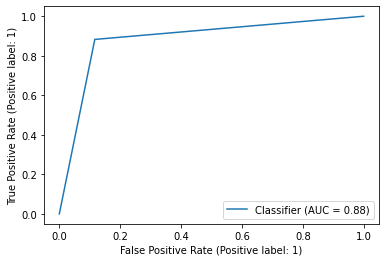

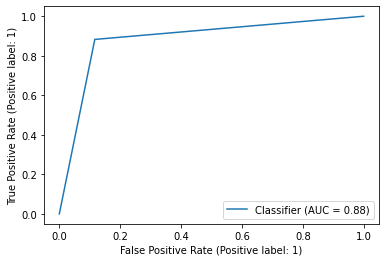

F1 SCORE:  0.8504983388704319
PERMUTATION
xgboost important feature #0: c58_gamma
xgboost feature weighted score: 10
shap important feature #0: c58_gamma
shap feature weighted score: 10
perm important feature #0: gamma_af3
shap feature weighted score: 10
perm important feature #0: gamma_af3
shap feature weighted score: 10
xgboost important feature #1: c14_beta
xgboost feature weighted score: 9
shap important feature #1: delta_fp1
shap feature weighted score: 9
perm important feature #1: c58_gamma
shap feature weighted score: 9
perm important feature #1: c58_gamma
shap feature weighted score: 9
xgboost important feature #2: c18_gamma
xgboost feature weighted score: 8
shap important feature #2: c03_beta
shap feature weighted score: 8
perm important feature #2: c03_beta
shap feature weighted score: 8
perm important feature #2: c48_beta
shap feature weighted score: 8
xgboost important feature #3: c45_gamma
xgboost feature weighted score: 7
shap important feature #3: c14_beta
shap feature w

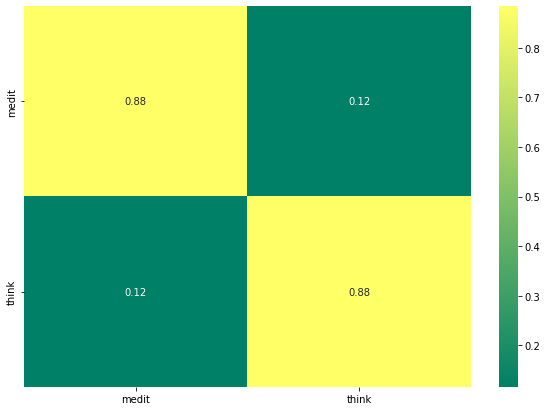

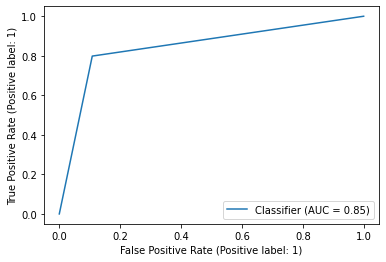

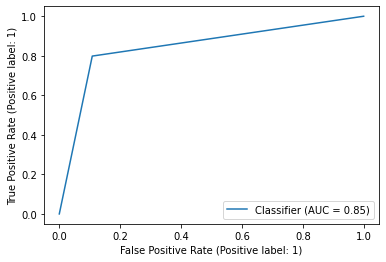

F1 SCORE:  0.7984496124031008
PERMUTATION
xgboost important feature #0: c01_gamma
xgboost feature weighted score: 10
shap important feature #0: c18_gamma
shap feature weighted score: 14
perm important feature #0: c58_beta
shap feature weighted score: 12
perm important feature #0: c58_beta
shap feature weighted score: 10
xgboost important feature #1: c48_beta
xgboost feature weighted score: 10
shap important feature #1: c58_beta
shap feature weighted score: 9
perm important feature #1: gamma_af3
shap feature weighted score: 19
perm important feature #1: gamma_afz
shap feature weighted score: 9
xgboost important feature #2: c47_gamma
xgboost feature weighted score: 10
shap important feature #2: delta_fp1
shap feature weighted score: 17
perm important feature #2: c18_gamma
shap feature weighted score: 15
perm important feature #2: c46_gamma
shap feature weighted score: 8
xgboost important feature #3: gamma_af3
xgboost feature weighted score: 13
shap important feature #3: gamma_afz
shap fe

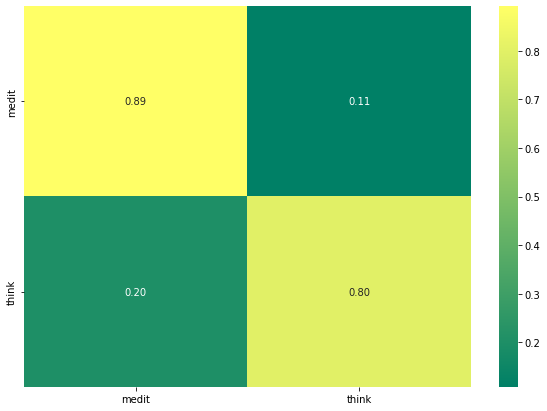

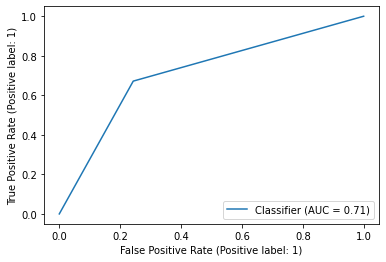

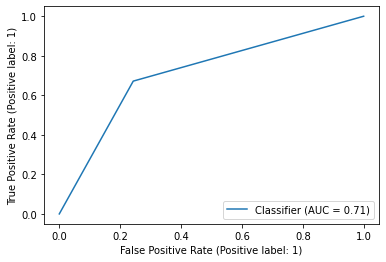

F1 SCORE:  0.6254545454545455
PERMUTATION
xgboost important feature #0: c01_gamma
xgboost feature weighted score: 20
shap important feature #0: gamma_af3
shap feature weighted score: 10
perm important feature #0: c45_gamma
shap feature weighted score: 13
perm important feature #0: c01_gamma
shap feature weighted score: 10
xgboost important feature #1: c38_gamma
xgboost feature weighted score: 17
shap important feature #1: c18_gamma
shap feature weighted score: 23
perm important feature #1: c25_beta
shap feature weighted score: 9
perm important feature #1: c45_gamma
shap feature weighted score: 10
xgboost important feature #2: c46_gamma
xgboost feature weighted score: 8
shap important feature #2: c48_gamma
shap feature weighted score: 8
perm important feature #2: c01_gamma
shap feature weighted score: 8
perm important feature #2: c37_gamma
shap feature weighted score: 8
xgboost important feature #3: gamma_af3
xgboost feature weighted score: 20
shap important feature #3: c01_gamma
shap f

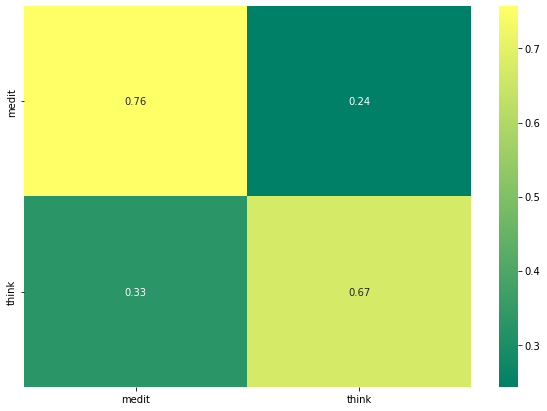

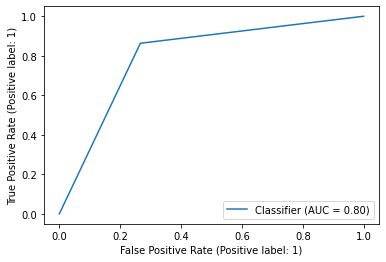

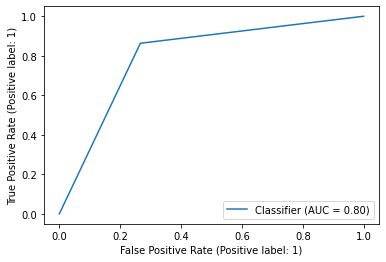

F1 SCORE:  0.7499999999999999
PERMUTATION
xgboost important feature #0: c58_beta
xgboost feature weighted score: 15
shap important feature #0: c04_beta
shap feature weighted score: 10
perm important feature #0: c45_gamma
shap feature weighted score: 23
perm important feature #0: c25_beta
shap feature weighted score: 13
xgboost important feature #1: c25_beta
xgboost feature weighted score: 10
shap important feature #1: c18_gamma
shap feature weighted score: 32
perm important feature #1: gamma_af3
shap feature weighted score: 28
perm important feature #1: gamma_af3
shap feature weighted score: 32
xgboost important feature #2: c38_gamma
xgboost feature weighted score: 25
shap important feature #2: c48_beta
shap feature weighted score: 12
perm important feature #2: c04_beta
shap feature weighted score: 8
perm important feature #2: gamma_af4
shap feature weighted score: 8
xgboost important feature #3: c45_gamma
xgboost feature weighted score: 17
shap important feature #3: c46_gamma
shap fea

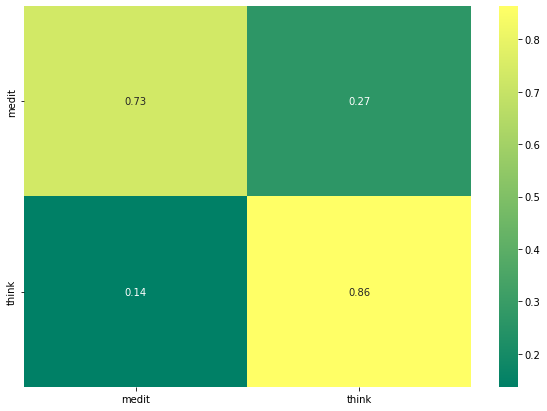

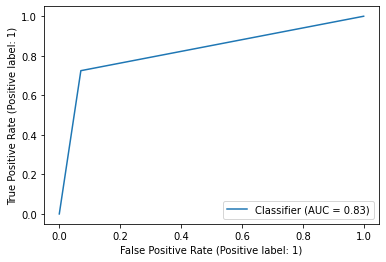

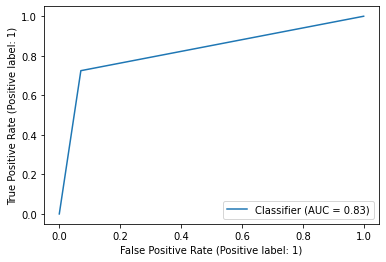

F1 SCORE:  0.7843137254901961
PERMUTATION
xgboost important feature #0: c45_gamma
xgboost feature weighted score: 27
shap important feature #0: delta_fp1
shap feature weighted score: 35
perm important feature #0: c58_beta
shap feature weighted score: 28
perm important feature #0: c58_beta
shap feature weighted score: 20
xgboost important feature #1: c58_gamma
xgboost feature weighted score: 21
shap important feature #1: c48_gamma
shap feature weighted score: 17
perm important feature #1: c12_beta
shap feature weighted score: 9
perm important feature #1: c45_gamma
shap feature weighted score: 21
xgboost important feature #2: c48_gamma
xgboost feature weighted score: 10
shap important feature #2: c58_beta
shap feature weighted score: 17
perm important feature #2: gamma_af3
shap feature weighted score: 36
perm important feature #2: c01_gamma
shap feature weighted score: 18
xgboost important feature #3: c38_gamma
xgboost feature weighted score: 32
shap important feature #3: c78_alpha
shap 

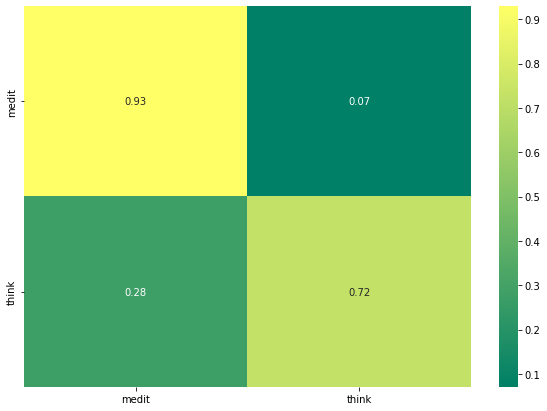

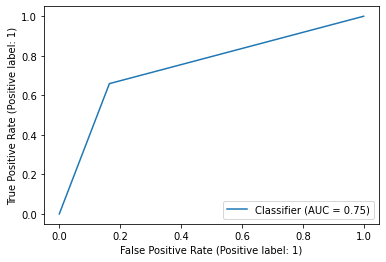

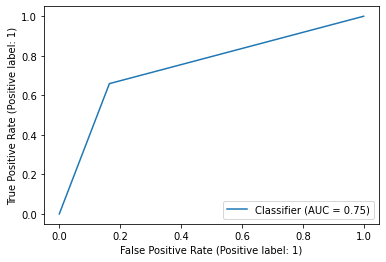

F1 SCORE:  0.6718146718146718
PERMUTATION
xgboost important feature #0: c38_gamma
xgboost feature weighted score: 42
shap important feature #0: c38_gamma
shap feature weighted score: 26
perm important feature #0: gamma_af3
shap feature weighted score: 46
perm important feature #0: gamma_af3
shap feature weighted score: 42
xgboost important feature #1: c14_beta
xgboost feature weighted score: 18
shap important feature #1: c18_gamma
shap feature weighted score: 41
perm important feature #1: c18_gamma
shap feature weighted score: 24
perm important feature #1: c14_beta
shap feature weighted score: 12
xgboost important feature #2: c01_gamma
xgboost feature weighted score: 38
shap important feature #2: c03_beta
shap feature weighted score: 24
perm important feature #2: delta_fp1
shap feature weighted score: 16
perm important feature #2: c03_beta
shap feature weighted score: 26
xgboost important feature #3: c04_gamma
xgboost feature weighted score: 7
shap important feature #3: gamma_afz
shap 

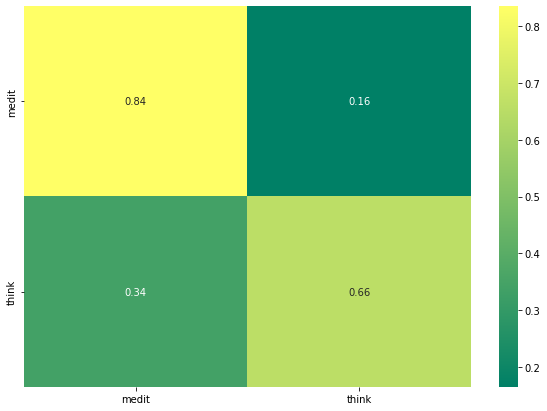

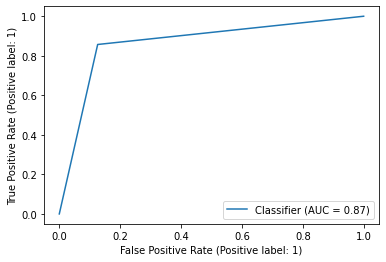

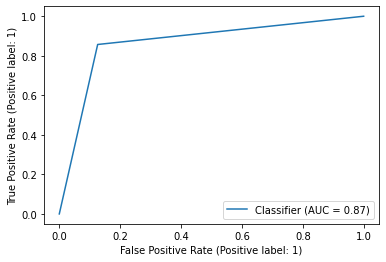

F1 SCORE:  0.8212927756653992
PERMUTATION
xgboost important feature #0: c38_gamma
xgboost feature weighted score: 52
shap important feature #0: c58_beta
shap feature weighted score: 27
perm important feature #0: gamma_af3
shap feature weighted score: 56
perm important feature #0: gamma_af3
shap feature weighted score: 52
xgboost important feature #1: c78_delta
xgboost feature weighted score: 21
shap important feature #1: c01_gamma
shap feature weighted score: 21
perm important feature #1: c58_beta
shap feature weighted score: 37
perm important feature #1: c01_gamma
shap feature weighted score: 32
xgboost important feature #2: gamma_af3
xgboost feature weighted score: 44
shap important feature #2: c58_gamma
shap feature weighted score: 27
perm important feature #2: c04_gamma
shap feature weighted score: 8
perm important feature #2: c04_gamma
shap feature weighted score: 17
xgboost important feature #3: c58_beta
xgboost feature weighted score: 24
shap important feature #3: c78_delta
shap

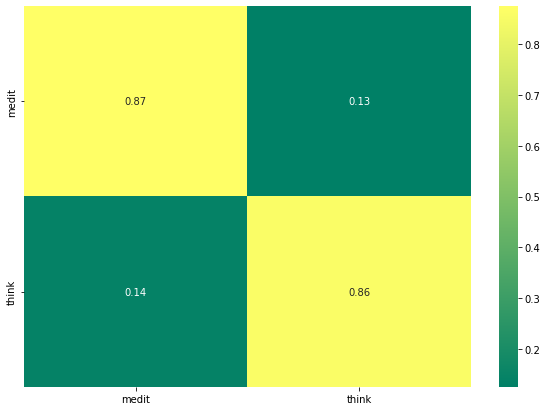

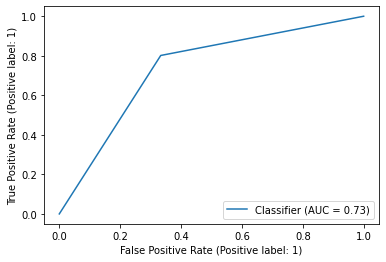

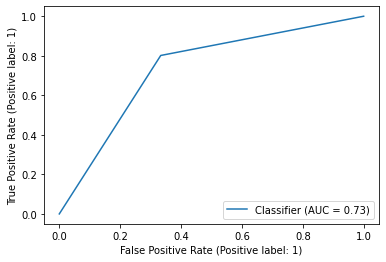

F1 SCORE:  0.6537216828478964
PERMUTATION
xgboost important feature #0: c48_beta
xgboost feature weighted score: 28
shap important feature #0: c58_beta
shap feature weighted score: 37
perm important feature #0: gamma_af3
shap feature weighted score: 66
perm important feature #0: gamma_af3
shap feature weighted score: 62
xgboost important feature #1: c01_gamma
xgboost feature weighted score: 52
shap important feature #1: c18_gamma
shap feature weighted score: 54
perm important feature #1: delta_fp1
shap feature weighted score: 25
perm important feature #1: c03_beta
shap feature weighted score: 35
xgboost important feature #2: gamma_af3
xgboost feature weighted score: 52
shap important feature #2: c46_gamma
shap feature weighted score: 20
perm important feature #2: c01_gamma
shap feature weighted score: 25
perm important feature #2: c02_beta
shap feature weighted score: 8
xgboost important feature #3: gamma_af4
xgboost feature weighted score: 21
shap important feature #3: c01_gamma
shap 

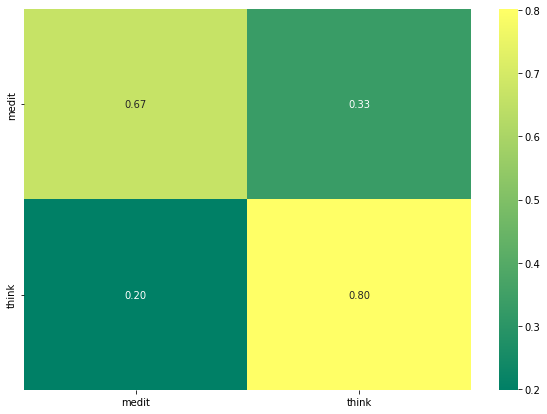

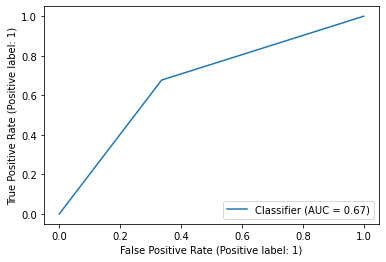

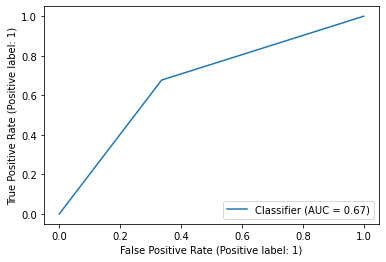

F1 SCORE:  0.5890410958904111
PERMUTATION
xgboost important feature #0: gamma_af4
xgboost feature weighted score: 31
shap important feature #0: c18_gamma
shap feature weighted score: 64
perm important feature #0: c03_beta
shap feature weighted score: 38
perm important feature #0: c14_beta
shap feature weighted score: 22
xgboost important feature #1: c46_gamma
xgboost feature weighted score: 22
shap important feature #1: c12_theta
shap feature weighted score: 17
perm important feature #1: c14_beta
shap feature weighted score: 15
perm important feature #1: c45_gamma
shap feature weighted score: 30
xgboost important feature #2: c48_gamma
xgboost feature weighted score: 18
shap important feature #2: gamma_af4
shap feature weighted score: 18
perm important feature #2: c12_beta
shap feature weighted score: 17
perm important feature #2: c12_theta
shap feature weighted score: 8
xgboost important feature #3: c12_theta
xgboost feature weighted score: 7
shap important feature #3: c46_gamma
shap f

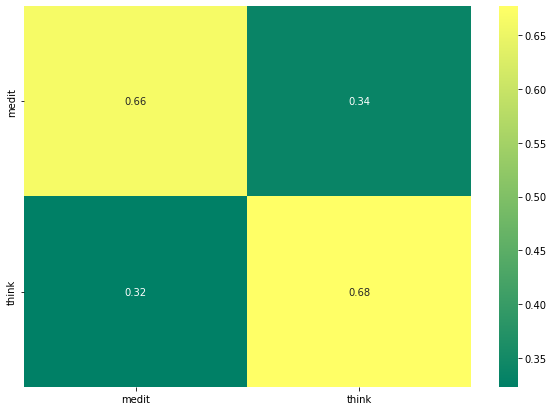

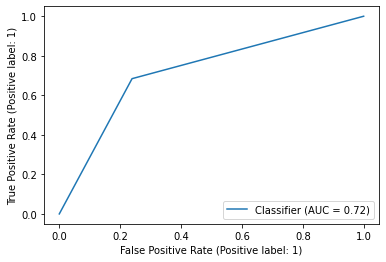

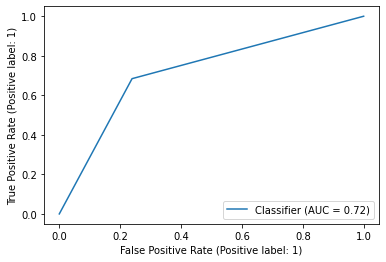

F1 SCORE:  0.6408450704225351
PERMUTATION
xgboost important feature #0: c18_gamma
xgboost feature weighted score: 19
shap important feature #0: c48_gamma
shap feature weighted score: 34
perm important feature #0: gamma_af3
shap feature weighted score: 79
perm important feature #0: c25_theta
shap feature weighted score: 14
xgboost important feature #1: c01_gamma
xgboost feature weighted score: 65
shap important feature #1: gamma_af3
shap feature weighted score: 19
perm important feature #1: c25_theta
shap feature weighted score: 20
perm important feature #1: c01_gamma
shap feature weighted score: 44
xgboost important feature #2: gamma_af3
xgboost feature weighted score: 65
shap important feature #2: c18_gamma
shap feature weighted score: 72
perm important feature #2: c48_gamma
shap feature weighted score: 18
perm important feature #2: c07_beta
shap feature weighted score: 15
xgboost important feature #3: c25_theta
xgboost feature weighted score: 16
shap important feature #3: c03_alpha
s

AttributeError: ignored

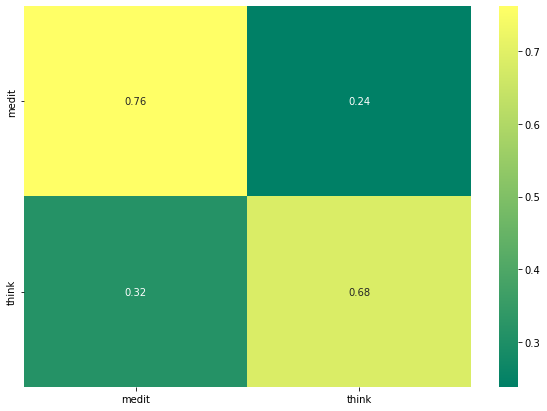

In [ ]:
import statistics

top_count = 10
xgb_weighted_scores = {}
shap_weighted_scores = {}
perm_weighted_scores_roc = {}
perm_weighted_scores_f1 = {}
auc_scores = []
f1_scores = []
acc_scores = []

for i in range(10):
  print(f"~~~~~~ running model for iteration #{i} ~~~~~~")
  (acc,auc,f1,xgb_imp,shap_imp,perm_imp_roc,perm_imp_f1) = runKfoldXgboost_s()
  acc_scores.append(acc)
  auc_scores.append(auc)
  f1_scores.append(f1)
  for j in range(top_count):
    cur_xgb = list(xgb_imp.keys())[j]
    print(f"xgboost important feature #{j}: {cur_xgb}")
    if cur_xgb in xgb_weighted_scores:
      #print("existing feature in xgboost dictionary- summing")
      xgb_weighted_scores[cur_xgb] = xgb_weighted_scores[cur_xgb] + (top_count-j)
    else:
      #print("new feature in xgboost dictionary- adding")
      xgb_weighted_scores[cur_xgb] = (top_count-j)
    print(f"xgboost feature weighted score: {xgb_weighted_scores[cur_xgb]}")

    cur_shap = shap_imp['col_name'].tolist()[j]
    print(f"shap important feature #{j}: {cur_shap}")
    if cur_shap in shap_weighted_scores:
      #print("existing feature in shap dictionary- summing")
      shap_weighted_scores[cur_shap] = shap_weighted_scores[cur_shap] + (top_count-j)
    else:
      #print("new feature in shap dictionary- adding")
      shap_weighted_scores[cur_shap] = (top_count-j)
    print(f"shap feature weighted score: {shap_weighted_scores[cur_shap]}")

    cur_perm_roc = list(perm_imp_roc.keys())[j]
    print(f"perm important feature #{j}: {cur_perm_roc}")
    if cur_perm_roc in perm_weighted_scores_roc:
      #print("existing feature in shap dictionary- summing")
      perm_weighted_scores_roc[cur_perm_roc] = perm_weighted_scores_roc[cur_perm_roc] + (top_count-j)
    else:
      #print("new feature in shap dictionary- adding")
      perm_weighted_scores_roc[cur_perm_roc] = (top_count-j)
    print(f"shap feature weighted score: {perm_weighted_scores_roc[cur_perm_roc]}")    
    
    cur_perm_f1 = list(perm_imp_f1.keys())[j]
    print(f"perm important feature #{j}: {cur_perm_f1}")
    if cur_perm_f1 in perm_weighted_scores_f1:
      #print("existing feature in shap dictionary- summing")
      perm_weighted_scores_f1[cur_perm_f1] = perm_weighted_scores_f1[cur_perm_f1] + (top_count-j)
    else:
      #print("new feature in shap dictionary- adding")
      perm_weighted_scores_f1[cur_perm_f1] = (top_count-j)
    print(f"shap feature weighted score: {perm_weighted_scores_f1[cur_perm_f1]}")

print("########### XGBOOST #############")
xgb_weighted_scores = dict(sorted(xgb_weighted_scores.items(), key=lambda item: item[1], reverse=True))
print(xgb_weighted_scores)
print("########### SHAP #############")
shap_weighted_scores = dict(sorted(shap_weighted_scores.items(), key=lambda item: item[1], reverse=True))
print(shap_weighted_scores)
print("########### PERMUTATION ROC #############")
perm_weighted_scores_roc = dict(sorted(perm_weighted_scores_roc.items(), key=lambda item: item[1], reverse=True))
print(perm_weighted_scores_roc)
print("########### PERMUTATION F1 #############")
perm_weighted_scores_f1 = dict(sorted(perm_weighted_scores_f1.items(), key=lambda item: item[1], reverse=True))
print(perm_weighted_scores_f1)
print(f"AVG ACC SCORE: {statistics.mean(acc_scores)}, full scores: {acc_scores}")
print(f"AVG AUC-ROC SCORE: {statistics.mean(auc_scores)}, full scores: {auc_scores}")
print(f"AVG F1 SCORE: {statistics.mean(f1_scores)}, full scores: {f1_scores}")

scores_sum_total = {xgb_weighted_scores.get(k, 0) + shap_weighted_scores.get(k, 0) + perm_weighted_scores_roc.get(k, 0) + perm_weighted_scores_f1.get(k, 0) for k in set(xgb_weighted_scores) | set(shap_weighted_scores) | set(perm_weighted_scores_roc) | set(perm_weighted_scores_f1)}
scores_sum_total = {key:val for key, val in scores_sum_total.items() if val > 100}

print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("after summing, these are the most important features:")
print(scores_sum_total)

#remove best features and re-test model
xgb_m = xgb.XGBClassifier()
loaded_model = xgb_m.load_model("/content/gdrive/My Drive/FA Research/models/XGBoost/XGBoost_model_May4.txt")

featuresToRemove = scores_sum_total.keys()
x_test = npy.load('/content/gdrive/My Drive/FA Research/models/XGBoost/x_test.npy')
x_test = x_test.drop(labels=featuresToRemove,axis=1)

y_true, y_pred = y_test, xgb_model.predict(x_test)

roc_auc_s = roc_auc_score(y_true, y_pred)
print(roc_auc_s)
f1 = f1_score(y_true,y_pred)
print(f"F1 SCORE:  {f1}")

cr = classification_report(y_true, y_pred, output_dict = True)
labels = ['medit', 'think']
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(cm)
cm = cm.astype(float)
acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
print (f"ACCURACY: {acc}")
  
cm_dict = {}
df1 = pd.DataFrame(cm, columns=labels, index=labels)
df2 = pd.DataFrame(cm/cm.sum(axis=1)[:,None], columns=labels, index=labels)
fig = plt.figure(figsize = (10,7))
sns.heatmap(df2, annot=True, fmt=".2f", cmap="summer")
fig.show()


In [ ]:
import statistics

auc_scores = []
f1_scores = []
acc_scores = []

for i in range(50):
  print(f"~~~~~~ running model for iteration #{i} ~~~~~~")
  (acc,auc,f1,xgb_imp,shap_imp,perm_imp_roc,perm_imp_f1) = runKfoldXgboost_s()
  acc_scores.append(acc)
  auc_scores.append(auc)
  f1_scores.append(f1)

print(f"AVG ACC SCORE: {statistics.mean(acc_scores)}, full scores: {acc_scores}")
print(f"AVG AUC-ROC SCORE: {statistics.mean(auc_scores)}, full scores: {auc_scores}")
print(f"AVG F1 SCORE: {statistics.mean(f1_scores)}, full scores: {f1_scores}")

In [ ]:
##### calibration bug drilldown
import random

sub = getSubjects()
sub_set = list(set(sub))
idx = int(len(sub_set)*0.2)
random.shuffle(sub_set)
sub_split = np.split(sub_set, [idx])
test_sub = sub_split[0]
train_sub = sub_split[1]
print(f"Test subjects: {test_sub}")
print(f"Train subjects: {train_sub}")
test_index = [i for i, x in enumerate(sub) if x in test_sub]
train_index = [i for i, x in enumerate(sub) if x in train_sub]

y_comp = get_y()
x_comp = get_raw_epochs()
test_cal_idx = []
train_cal_idx = []
for t_sub in test_sub:
  idx = np.where(np.isin(sub,t_sub))[0] # get all indices of subject
  labels = y_comp[idx] # get all labels of subject
  for cond in set(labels):
    cond_idx = np.where(np.isin(labels,cond))[0] # get all indices of condition and subject
    if cond in[2]: #breath
      print(f"BREATH epochs for subject {t_sub}- adding to training")
      train_start_idx = cond_idx[0]
      train_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.7)
      train_cal_idx = np.append(train_cal_idx,idx[train_start_idx:train_end_idx]) # first 30% of epochs to train
    elif cond in [0]: #medit
      print(f"MEDIT epochs for subject {t_sub}- adding to testing")
      test_start_idx = cond_idx[0]
      test_end_idx = cond_idx[0] + int(cond_idx.shape[0])
      test_cal_idx.append(idx[test_start_idx:test_end_idx]) # all epochs to test
    elif cond in [1]: #think
      print(f"THINK epochs for subject {t_sub}- adding first 40% to training and last 60% to testing")
      train_start_idx = cond_idx[0]
      train_end_idx = cond_idx[0] + int((cond_idx.shape[0])*0.3)
      test_start_idx = cond_idx[0] + int((cond_idx.shape[0])*0.3)
      test_end_idx = cond_idx[0] + int(cond_idx.shape[0])
      test_cal_idx.append(idx[test_start_idx:test_end_idx]) # last 70% of epochs to test
      train_cal_idx = np.append(train_cal_idx,idx[train_start_idx:train_end_idx]) # first 30% of epochs to train
    else:
      print("$$$$$$$$$$$$$$ ERRORRRRRRRRRRRRRRRRRRRRRRR $$$$$$$$$$$$$")

test_cal_idx = [item for sublist in test_cal_idx for item in sublist]
print(f"Added {train_cal_idx.shape} think epochs to calibration and {len(test_cal_idx)} medit epochs to test")
train_cal_idx = train_cal_idx.astype(int)

x_test = x_comp[test_index]
y_test = y_comp[test_index]

test_index = [item for item in test_index if item not in train_cal_idx]
print(f"{len(test_index)} test_index indices:")
print(test_index) 
y_total = get_y_no_breath()
print(y_total.shape)

x_test = np.concatenate((x_comp[test_index],x_comp[test_cal_idx]))
y_test = np.concatenate((y_total[test_index],y_total[test_cal_idx]))
x_train = np.concatenate((x_comp[train_index],x_comp[train_cal_idx]))
y_train = np.concatenate((y_total[train_index],y_total[train_cal_idx]))
print(f"### OLD CALIBRATION- test shape is {x_test.shape},{y_test.shape} and train shape is {x_train.shape},{y_train.shape}")
print(f"### OLD CALIBRATION- test indices 1 {test_index}")
print(f"### OLD CALIBRATION- test indices 2 {test_cal_idx}")
print(f"### OLD CALIBRATION- train indices 1 {train_index}")
print(f"### OLD CALIBRATION- train indices 2 {train_cal_idx}")
duplicates = np.array([i for i, x in enumerate(x_comp) if i in test_index and i in test_cal_idx])
print(f"### OLD CALIBRATION- {duplicates.shape} duplicate epochs in test set, "
+ f"meaning {duplicates.shape[0]/(x_test.shape[0]-duplicates.shape[0])} percent out of test set. \n" +
  f"duplicate indices are: {duplicates}")

train_indices = [i for i, x in enumerate(sub) if x in train_sub]
test_indices = [i for i, x in enumerate(sub) if x in test_sub]
calibration_indices = getCalibrationIndices(test_sub)
breath_indices = np.where(np.isin(y_comp,[2]))[0]
print(f"found {len(train_indices)} indices for training, {len(test_indices)} for testing and {len(breath_indices)} for breath")

#add calibration epochs of test subjects to training set
x_train_new = np.array([i for i, x in enumerate(x_comp) if (i in train_indices) or i in calibration_indices])
x_test_new = np.array([i for i, x in enumerate(x_comp) if i in test_indices and i not in calibration_indices])
print(f"### NEW CALIBRATION- test indices: {x_test_new.shape} and train indices: {x_train_new.shape}")
print(f"### NEW CALIBRATION- test indices {x_test_new}")
print(f"### NEW CALIBRATION- train indices {x_train_new}")

Test subjects: ['HT1' 'HT7' 'VIP06' 'HT13' 'HT26']
Train subjects: ['HT25' 'HT18' 'VIP2' 'VIP20' 'VIP15' 'VIP7' 'HT8' 'HT15' 'HT6' 'HT20'
 'VIP11' 'VIP1' 'VIP19' 'HT9' 'HT24' 'VIP3' 'VIP12' 'VIP13' 'VIP14'
 'VIP16' 'VIP5']
[0 1 2] [931 981 938]
(2850, 2560, 9)
(2850, 2560, 9, 1)
MEDIT epochs for subject HT1- adding to testing
THINK epochs for subject HT1- adding first 40% to training and last 60% to testing
BREATH epochs for subject HT1- adding to training
MEDIT epochs for subject HT7- adding to testing
THINK epochs for subject HT7- adding first 40% to training and last 60% to testing
BREATH epochs for subject HT7- adding to training
MEDIT epochs for subject VIP06- adding to testing
THINK epochs for subject VIP06- adding first 40% to training and last 60% to testing
BREATH epochs for subject VIP06- adding to training
MEDIT epochs for subject HT13- adding to testing
THINK epochs for subject HT13- adding first 40% to training and last 60% to testing
BREATH epochs for subject HT13- adding